In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm

from shamans.utils import eval_utils as eval

In [13]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False)
    return combined_csv

In [14]:
# load data
exp_id = 2
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])

print(exp_df['loc_algo'].unique())

['srp' 'alp' 'mus']


In [15]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666   
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666


In [16]:
# n_sources_choice = [1]
# source_type_choices = ['speech']
# snr_choices = np.arange(-30, 31, 10).tolist()
# noise_type_choices = ['awgn', 'alpha-1.2', 'alpha-0.8']
# sound_duration_choices = [0.5]
# add_reverb_choices = [False]

print(exp_df['sep_angle'].unique())
print()
print(exp_df['sv_model'].unique())
print(exp_df['seed'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())

[ 6 12 18 24 30 36 42]

['ref' 'alg' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
[666]
['awgn']
[3]
[20]
[1.]
[0.    0.123 0.273]
['srp_phat' 'alpha-2.0_beta-2_eps-1E-3_iter-500'
 'alpha-1.2_beta-0_eps-1E-3_iter-500' 'music_s-3'
 'alpha-1.2_beta-2_eps-1E-3_iter-500' 'alpha-1.2_beta-1_eps-1E-3_iter-500']


In [17]:
exp_df = exp_df[
    (exp_df['loc_method'].isin([
        'alpha-1.2_beta-1_eps-1E-3_iter-500',
        'music_s-3',
        'srp_phat'])) &
    (exp_df['rt60'] > 0) &
    (exp_df['sv_model'].isin(['ref', 'alg', 'gp-steerer_64'])) 
]
print(len(exp_df))

print(exp_df['sep_angle'].unique())
print()
print(exp_df['sv_model'].unique())
print(exp_df['seed'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())


3780
[ 6 12 18 24 30 36 42]

['ref' 'alg' 'gp-steerer_64']
[666]
['awgn']
[3]
[20]
[1.]
[0.123 0.273]
['srp_phat' 'music_s-3' 'alpha-1.2_beta-1_eps-1E-3_iter-500']


In [18]:
unique_method_ids = exp_df['method_id'].unique()
unique_frame_ids = exp_df['frame_id'].unique()

print(unique_method_ids)

['srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'srp_phat_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'srp_phat_freqs-[200, 4000]_gp-steerer_nObs-64_seed-666_norm-True'
 'music_s-3_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'music_s-3_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'music_s-3_freqs-[200, 4000]_gp-steerer_nObs-64_seed-666_norm-True'
 'alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-64_seed-666_norm-True']


# SNR vs METHOD per RT60

In [23]:
df_success_num_sources = pd.DataFrame()

thresh = 30

print('Method', len(unique_method_ids))
print('Frame', len(unique_frame_ids))

for method_id in unique_method_ids:
    for frame_id in unique_frame_ids:
        
        df_ = exp_df[
            (exp_df['method_id'] == method_id) & 
            (exp_df['frame_id'] == frame_id)
        ]

        doas_est = np.rad2deg(df_['doas_est_az'].values)
        doas_ref = np.rad2deg(df_['doas_ref_az'].values)
        
        print(method_id, len(doas_est))

        if len(doas_est) == 3:

            # compute individual and average error
            err = [eval.angular_difference(doas_est[j], doas_ref[j]) for j in range(2)]
            err_avg = np.mean(err)

            # number of sources resolved
            success = 0
            for p1, p2 in zip(doas_est, doas_ref):
                if eval.angular_difference(p1,p2) < thresh:
                    success += 1
            
            df_ = pd.DataFrame({
                'method_id': method_id,
                'frame_id': frame_id,
                'success': success,
                'err_avg': err_avg
            }, index=[0])
        else:
            print('Error')
            print(method_id, frame_id)
            print(doas_est)
        
        df_success_num_sources = pd.concat([df_success_num_sources, df_])

Method 9
Frame 140
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True 3
srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-Tr

In [24]:
df_exp2_results = df_success_num_sources.merge(exp_df, on=['method_id', 'frame_id'])

In [25]:
print(df_exp2_results['sep_angle'].unique())
print()
print(df_exp2_results['sv_model'].unique())
print(df_exp2_results['n_sources'].unique())
print(df_exp2_results['loc_method'].unique())

nice_plot_df = df_exp2_results[
    (df_exp2_results['sv_model'].isin(['ref', 'gp-steerer_8', 'gp-steerer_16', 'gp-steerer_32', 'gp-steerer_64', 'gp-steerer_128']))
    & (df_exp2_results['loc_method'].isin(['srp_phat', 'music_s-3', 'alpha-1.2_beta-1_eps-1E-3_iter-500']))
    & (df_exp2_results['rt60'] > -1)
    & (df_exp2_results['duration'] == 1.)
]

nice_plot_df.loc[nice_plot_df['loc_method'] == 'srp_phat', 'loc_method'] = 'SRP-PHAT'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'music_s-3', 'loc_method'] = 'MUSIC-3'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'ALPHA-1.2_BETA-1'

nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'sv_model'] = 'REF'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'sv_model'] = 'ALG'
for nObs in [8, 16, 32, 64, 128]:
    nice_plot_df.loc[nice_plot_df['sv_model'] == f'gp-steerer_{nObs}', 'sv_model'] = f'GP-STEERER-{nObs}'

algo_order = ['SRP-PHAT', 'MUSIC-3', 'ALPHA-1.2_BETA-1']

print(nice_plot_df['sv_model'].unique())
print(nice_plot_df['n_sources'].unique())
print(nice_plot_df['loc_method'].unique())


[ 6 12 18 24 30 36 42]

['ref' 'alg' 'gp-steerer_64']
[3]
['srp_phat' 'music_s-3' 'alpha-1.2_beta-1_eps-1E-3_iter-500']
['REF' 'GP-STEERER-64']
[3]
['SRP-PHAT' 'MUSIC-3' 'ALPHA-1.2_BETA-1']


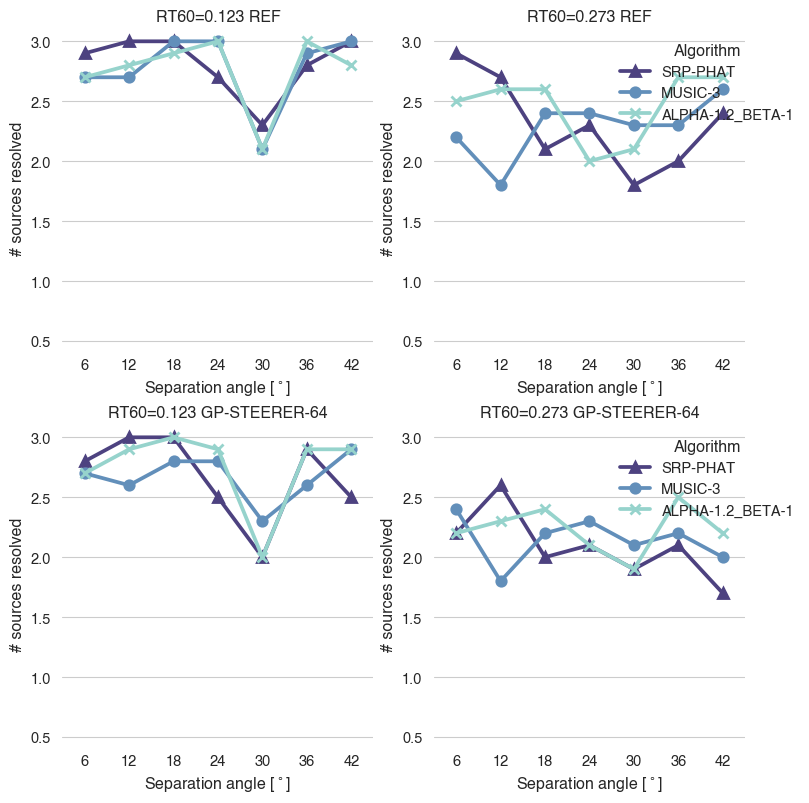

In [26]:
n_algo = len(df_exp2_results['loc_method'].unique())

markers = ['^','o','x','s','d','v'][:n_algo]


sns.set(
style='whitegrid', context='paper', font_scale=1.2,
        rc={
                'figure.figsize':(3.5,3.15), 
                'lines.linewidth':1.5,
                'font.family': 'sans-serif',
                'font.sans-serif': [u'Helvetica'],
                'text.usetex': False,
                })

pal = sns.cubehelix_palette(n_algo, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)

rt60s = nice_plot_df['rt60'].unique()
sv_models = nice_plot_df['sv_model'].unique()

fig, axarr = plt.subplots(len(sv_models), len(rt60s), figsize=(8,8))

for i, sv_model in enumerate(sv_models):
        for j, rt60 in enumerate(rt60s):

                ax = axarr[i,j]

                df_ = nice_plot_df[
                        (nice_plot_df['rt60'] == rt60)
                        & (nice_plot_df['sv_model'] == sv_model) 
                        ]

                sns.pointplot(
                        x='sep_angle',y='success',hue='loc_method',
                        data=df_[['sep_angle','success','loc_method']],
                        palette=pal,
                        markers=markers,
                        errorbar=None,
                        ax=axarr[i,j])

                # ax.text(-2.65, 1.965, 'B', fontsize=27, fontweight='bold')

                if j == len(rt60s) - 1:
                        leg = ax.legend(title='Algorithm', 
                                loc='upper right',
                                bbox_to_anchor=[1.2,1.], 
                                frameon=False, framealpha=0.4)
                        leg.get_frame().set_linewidth(0.0)
                else:
                        ax.get_legend().remove()

                ax.set_title(f'RT60={rt60} {sv_model}')

                ax.set_xlabel('Separation angle [$^\circ$]')
                ax.set_ylabel('# sources resolved')

                ax.set_ylim([0.45,3.1])
                ax.set_yticks(np.arange(0.5,3.5,0.5))

                sns.despine(offset=10, trim=False, left=True, bottom=True, ax=ax)

plt.tight_layout(pad=0.5)
plt.show()